# Product Recommendations (k-Nearest Neighbors)

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing, model_selection, metrics

import math

# For plotting nice figures
%matplotlib inline
sns.set()
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Load Purchases Data

In [2]:
# Load data
df = pd.read_csv('../Data/purchases.csv')
df.head()

,ID,Age,Gender,Income,Married,Product
0,1,37,Female,62000,No,B
1,2,30,Male,74500,Yes,C
2,3,59,Female,94000,Yes,A
3,4,34,Female,63500,No,B
4,5,37,Female,84000,No,A


### Exercise

Using age and income, calculate the Manhattan and Euclidean distances between the first two customers in the dataset.

## Numerical Representations of Categorical Data

In [3]:
# Convert Gender and Married to a numerical representation
df = pd.get_dummies(df, columns=['Gender', 'Married'])
df = df.drop(['ID', 'Gender_Male', 'Married_No'], axis=1)
df.head()

,Age,Income,Product,Gender_Female,Married_Yes
0,37,62000,B,1,0
1,30,74500,C,0,1
2,59,94000,A,1,1
3,34,63500,B,1,0
4,37,84000,A,1,0


### Exercise

Calculate the Euclidean distance between the first two records according to age, income, gender, and marital status.

## Feature Scaling

In [4]:
# Classify Product as a function of the remaining 
# variables (Age, Income, Gender, Married)

# Use the convention that the label is y and the features are X
y = df['Product']
X = df.drop('Product', axis=1)

In [5]:
# Scale the data to be between 0 and 1
scaler = preprocessing.MinMaxScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)
X_scaled.head()

,Age,Income,Gender_Female,Married_Yes
0,0.463415,0.408654,1.0,0.0
1,0.292683,0.528846,0.0,1.0
2,1.000000,0.716346,1.0,1.0
3,0.390244,0.423077,1.0,0.0
4,0.463415,0.620192,1.0,0.0


## Train-Test Splits

In [6]:
# Split data into training and test sets
(X_train, X_test,
 y_train, y_test) = model_selection.train_test_split(X_scaled, y,
                                                     test_size=0.2)

## Fitting a model

In [7]:
# Fit the model on the training data using an arbitrary value of k
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [8]:
# For the training data, record the actual and predicted classes in
# a dataframe for viewing
df_temp = pd.DataFrame({
    'Actual':y_train,
    'Predicted':knn.predict(X_train),
})
df_temp['Match'] = (df_temp['Actual'] == df_temp['Predicted'])
df_temp.head(n=10)

,Actual,Predicted,Match
178,D,C,False
6676,D,D,True
6059,D,D,True
4245,D,C,False
8576,A,A,True
7203,C,C,True
6245,C,C,True
2844,B,B,True
1629,B,B,True
4869,C,C,True


In [9]:
# What percent of instances does the model correctly classify
# for the training data?
df_temp['Match'].mean()

0.747625

### Exercise

Using the training data, manually try different values of k and record the performance in terms of the percent of correct classifications

### Exercise

Automate the evaluation of k over the interval \[10, 100\]. Find the best value of k in that interval based on the percent of correct classifications for the training data

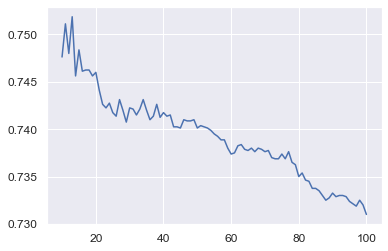

In [10]:
ks = range(10, 101)
accuracies = []

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_train)
    match = (predictions == y_train)
    accuracies += [match.mean()]
    
plt.plot(ks, accuracies)
plt.show()

## Making Predictions for New Customers

In [11]:
# Input new customers
X_new_mat = [
    [25, 90000, 1, 0],
    [55, 30000, 1, 0],
    [50, 70000, 1, 1],
    [25, 75000, 0, 0],
    [58, 45000, 0, 0],
    [28, 70000, 0, 1]
]

# Carry through feature names
X_new = pd.DataFrame(X_new_mat, columns=X.columns)

# Scale new customer data
X_new = pd.DataFrame(scaler.transform(X_new), columns=X.columns)

# Predict products
knn.predict(X_new)

array(['B', 'B', 'B', 'C', 'C', 'D'], dtype=object)

In [12]:
# Calculate probabilities
knn.predict_proba(X_new)

array([[0.33, 0.67, 0.  , 0.  ],
       [0.25, 0.75, 0.  , 0.  ],
       [0.29, 0.71, 0.  , 0.  ],
       [0.  , 0.  , 0.66, 0.34],
       [0.  , 0.  , 0.54, 0.46],
       [0.  , 0.  , 0.43, 0.57]])

## Fitting a Model with Cross-Validation

In [13]:
neighbors = list(range(5, 300, 5))

# Cross-validate using a 10-fold approach:
# For each possible value of k, fit the model 10 times,
# randomly leaving out 1/10 of the training data
# to use for performance evaluation
percent_correct = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = model_selection.cross_val_score(knn, X_train, y_train, cv=10,
                                             scoring='accuracy')
    percent_correct.append(100 * scores.mean())

In [14]:
# Determine the best value of k
k_best = neighbors[np.argmax(percent_correct)]
k_best

50

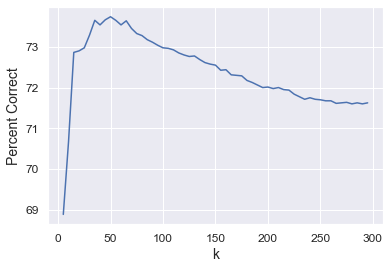

In [15]:
# Plot percent correct vs. k
plt.plot(neighbors, percent_correct)
plt.xlabel('k')
plt.ylabel('Percent Correct')
plt.show()

In [16]:
# Fit the model for the best value of k
knn = KNeighborsClassifier(n_neighbors=k_best)
knn.fit(X_train, y_train)

# Predict outcomes
y_pred = knn.predict(X_test)

# Get accuracy (percent of correct labels) on test data
metrics.accuracy_score(y_test, y_pred)

0.736

### Exercise

Why might the optimal value of k vary when you run this notebook repeatedly?